In [ ]:
import matplotlib.pyplot as plt
import numpy as np


from torchvision import datasets, transforms
from torch.utils.data import DataLoader


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(0)

### Data Handler

In [115]:
# train_transforms = transforms.Compose([
#                                        transforms.Resize(255),                             
#                                        transforms.RandomRotation(30),                      
#                                        transforms.RandomResizedCrop(224),                  
#                                        transforms.RandomHorizontalFlip(),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize([0.5, 0.5, 0.5],
#                                                             [0.5, 0.5, 0.5])
#                                       ]) 



# test_transforms = transforms.Compose([
#                                       transforms.Resize(255),
#                                       transforms.CenterCrop(224),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize([0.5, 0.5, 0.5],
#                                                            [0.5, 0.5, 0.5])
#                                      ])

# Define a transform to normalize the data (Preprocessing) and cast to tensor
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

# Download and load the training data
trainset = datasets.ImageFolder('C:\\Users\\ritth\\code\\Data\\archive (1)\\train', transform= transform)
trainloader = DataLoader(trainset, batch_size= 32, shuffle= True)


# Download and load the test data
testset = datasets.ImageFolder('C:\\Users\\ritth\\code\\Data\\archive (1)\\test', transform= transform)
testloader = DataLoader(testset, batch_size= 32, shuffle= False)


print(trainloader.dataset)
print(testloader.dataset)

Dataset ImageFolder
    Number of datapoints: 58388
    Root location: C:\Users\ritth\code\Data\archive (1)\train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
Dataset ImageFolder
    Number of datapoints: 2000
    Root location: C:\Users\ritth\code\Data\archive (1)\test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


### Class

In [116]:
len(testset.classes)

400

### Visualize

In [117]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '212')

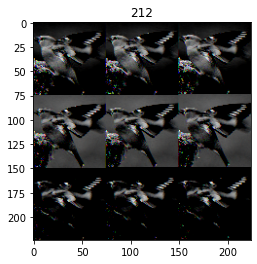

In [118]:
imgs, labels = iter(trainloader).next()

# visualize
plt.imshow(imgs[0].view(224, 224, 3))
plt.title(f'{labels[0]}')

### Model

In [119]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 2, 2)     
        self.pool = nn.MaxPool2d(2, 2)       
        self.conv2 = nn.Conv2d(64, 32, 3, 2)    
        self.fc1 = nn.Linear(32*13*13, 156)
        self.fc2 = nn.Linear(156, 84)
        self.fc3 = nn.Linear(84, 400)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(x.shape[0], -1)   
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x


model = Net()

In [120]:
optimizer = optim.Adam(model.parameters(), lr= 0.001)
criterion = nn.NLLLoss()


### Training and Validation

In [121]:

epochs = 15 


train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
benchmark_accuracy = 0.90


for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    running_accuracy = 0
    running_loss = 0
    # training
    for x_train_batch, y_train_batch in trainloader:
        
        optimizer.zero_grad()

        # forward pass
        logits = model(x_train_batch)
        train_preds = torch.argmax(logits.detach(), dim=1)
        
        # loss
        train_loss = criterion(logits, y_train_batch)
        running_loss += train_loss.item()

        # train accuracy
        train_acc = (y_train_batch == train_preds).sum() / len(y_train_batch)
        running_accuracy += train_acc.item()

        # backward pass
        
        train_loss.backward()
        
        # update paramaters
        
        optimizer.step()

    # mean loss (all batches losses divided by the total number of batches)
    train_losses.append(running_loss / len(trainloader))
    
    # mean accuracies
    train_accuracies.append(running_accuracy / len(trainloader))
    
    # print
    print(f'Train loss: {train_losses[-1] :.4f}')

    # validation
    model.eval()
    with torch.no_grad():
        running_accuracy = 0
        running_loss = 0

        for x_test_batch, y_test_batch in testloader:
            
            # logits
            test_logits = model(
                x_test_batch)

            # predictions
            test_preds = torch.argmax(test_logits, dim=1)
            
            # accuracy
            test_acc = (y_test_batch == test_preds).sum() / len(y_test_batch)
            running_accuracy += test_acc

            # loss
            test_loss = criterion(test_logits, y_test_batch)
            running_loss += test_loss

        # mean accuracy for each epoch
        test_accuracies.append(running_accuracy / len(testloader))

        # mean loss for each epoch
        test_losses.append(running_accuracy / len(testloader))
        # print
        print(f'Test accuracy: {test_accuracies[-1]*100 :.2f}%')
        print('='*100)
        # saving best model
        # is current mean score (mean per epoch) greater than or equal to the benchmark?
        if test_accuracies[-1] > benchmark_accuracy:
            # save model to cpu
            torch.save(model.to('cpu').state_dict(), './model.pth')
            

            # update benckmark
            benchmark_accuracy = test_accuracies[-1]

    model.train()

Epoch 1/15


KeyboardInterrupt: 